In [1]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
# These top lines are critical for import from another folder
sys.path.insert(1, '/net/capricorn/home/xing/huijing/Segmentation/scripts/vimentin_DIC_segmentation_pipeline/hj_modify_pipe')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from os import listdir
import cv2
from skimage.io import imread
import numpy as np
from resnet50_nc import res_model
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.filters import gaussian
from unsharp_mask import unsharp_mask
from skimage.exposure import equalize_adapthist,rescale_intensity
from matplotlib import pyplot as plt
from sklearn.utils import class_weight
import tensorflow as tf
from cnn_prep_data import prep_icnn_am_train_data

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 96557862238133173
]


In [3]:
train_path='/home/zoro/Desktop/HK2_train_data/HK2_am_icnn_train/train'
#val_path='/home/zoro/Desktop/HK2_traj/xy02/crop/val'
weight_file='HK2_icnn_am.hdf5'

In [4]:
obj_h=128
obj_w=128
input_shape=(obj_h,obj_w,1)
nb_class=3
model=res_model(input_shape,nb_class)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 64)   0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [5]:
data_gen = ImageDataGenerator(rotation_range=180,zoom_range=(1,1.25), horizontal_flip=True,vertical_flip=True)

/home/zoro/anaconda2/lib/python2.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


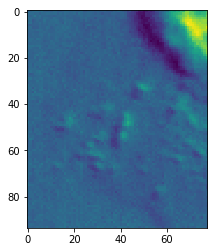

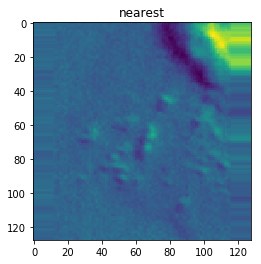

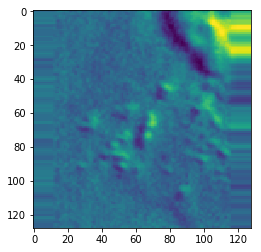

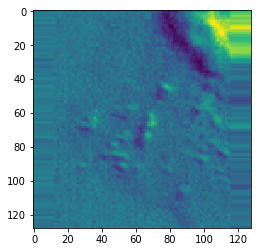

(128, 128, 1)


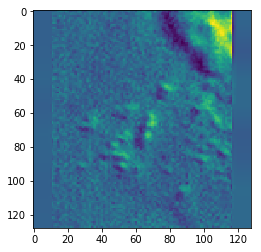

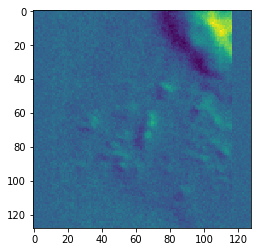

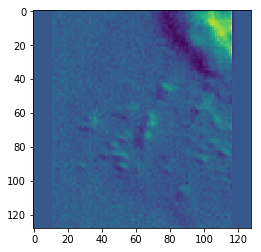

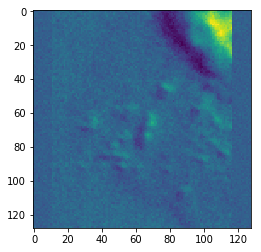

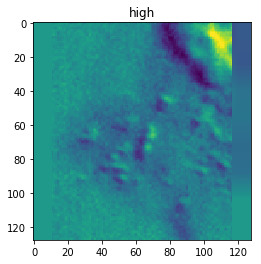

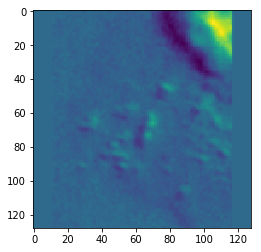

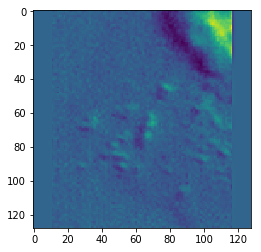

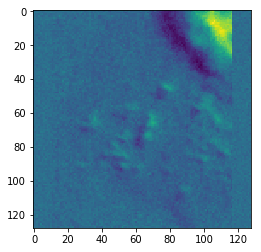

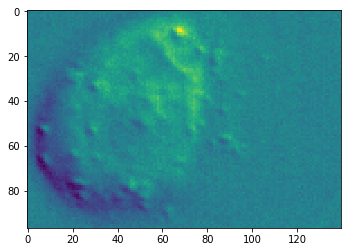

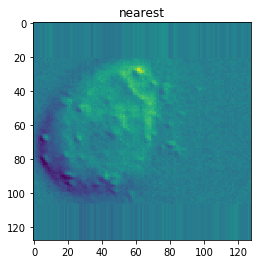

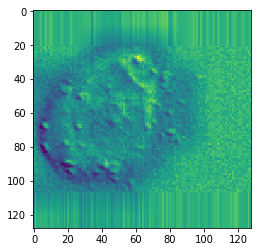

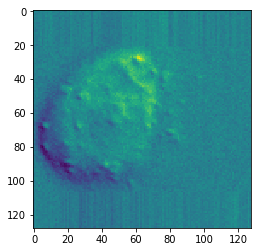

(128, 128, 1)


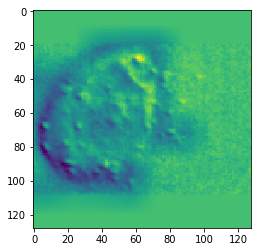

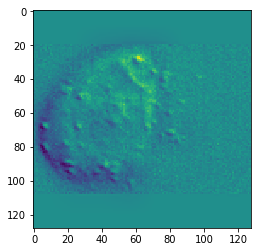

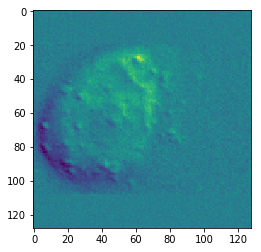

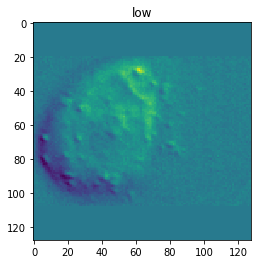

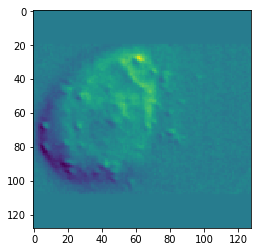

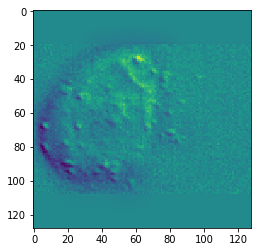

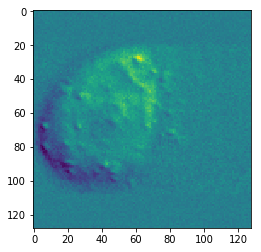

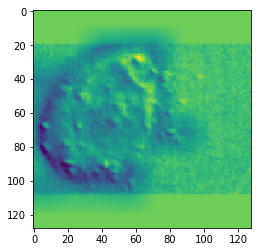

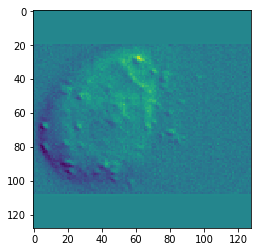

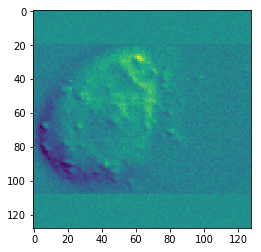

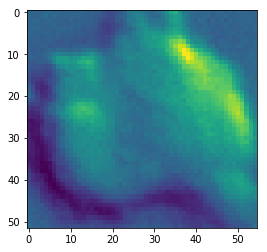

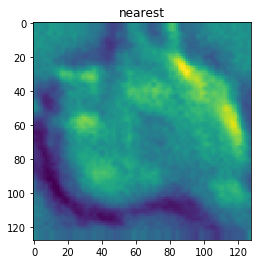

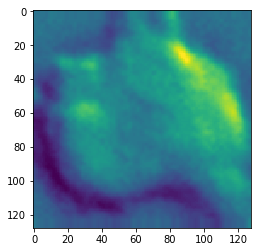

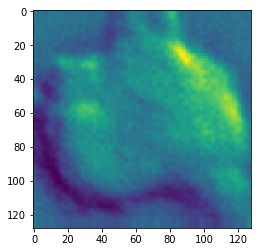

(128, 128, 1)


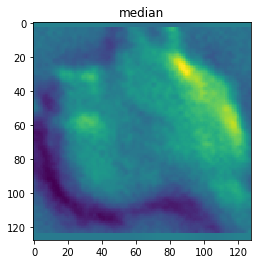

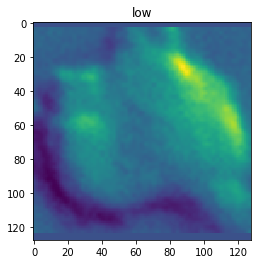

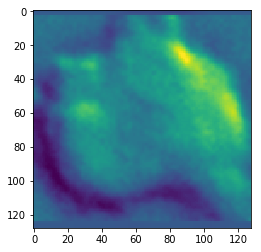

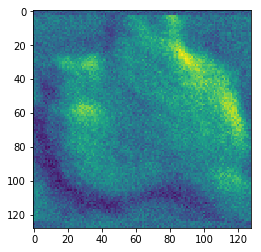

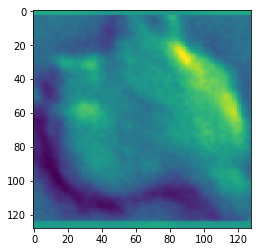

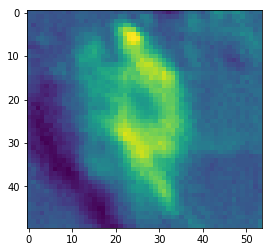

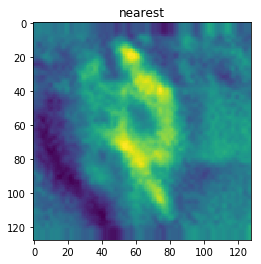

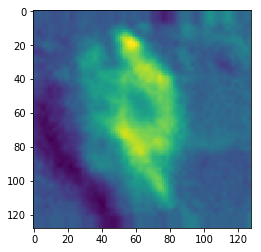

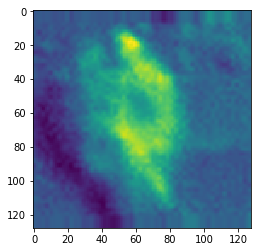

(128, 128, 1)


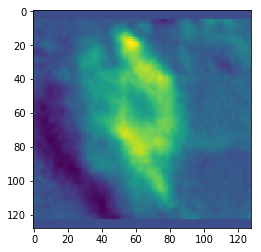

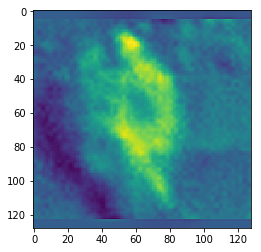

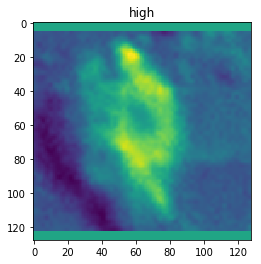

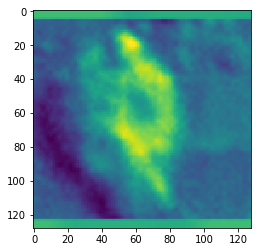

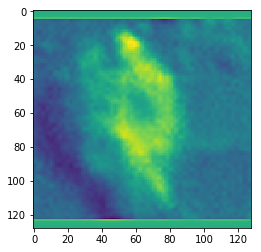

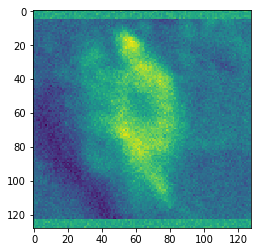

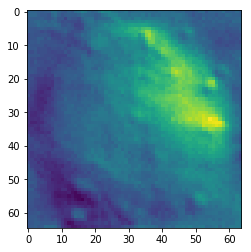

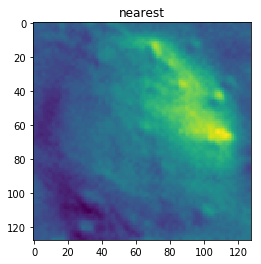

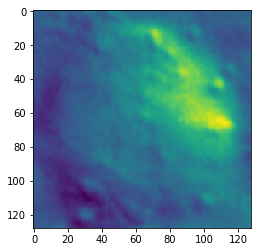

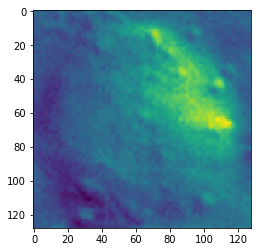

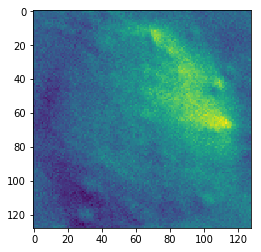

(128, 128, 1)


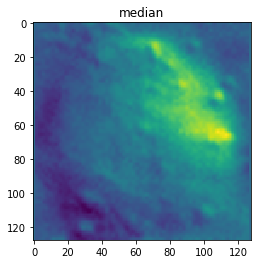

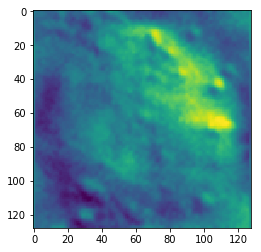

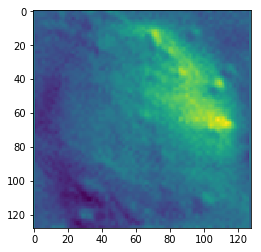

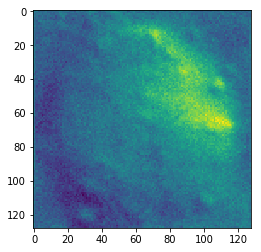

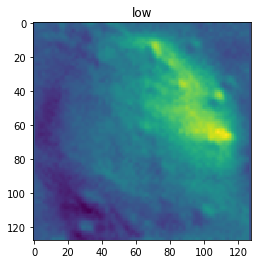

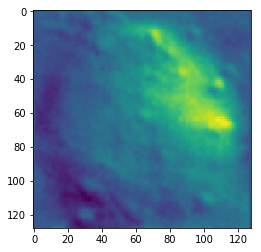

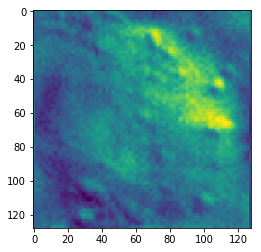

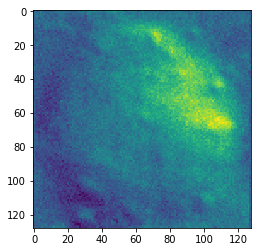

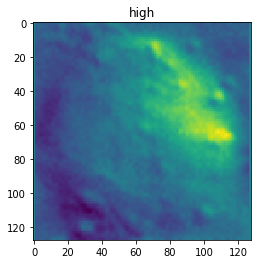

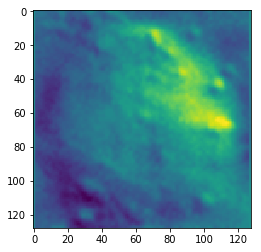

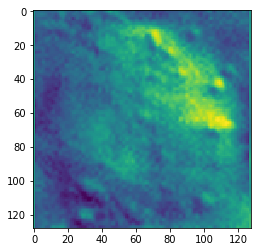

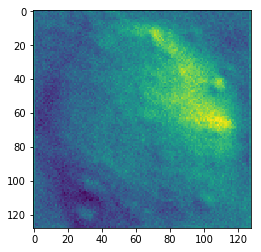

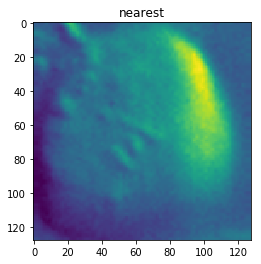

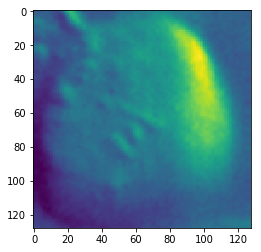

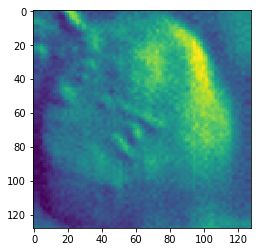

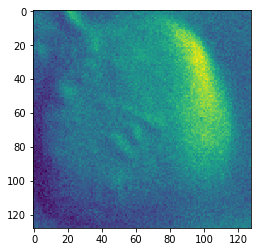

(128, 128, 1)


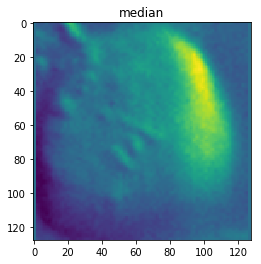

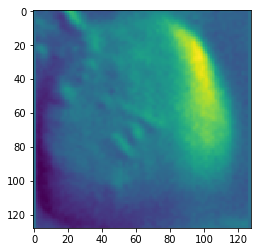

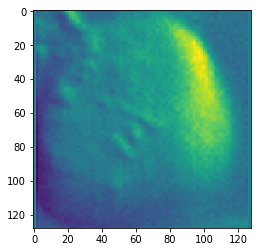

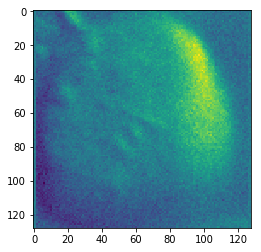

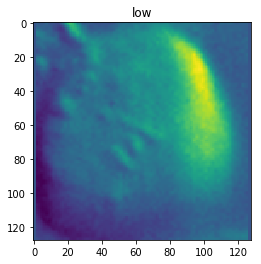

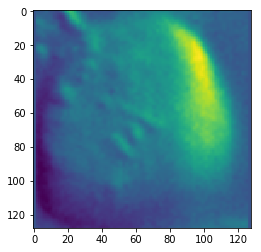

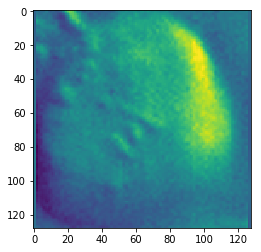

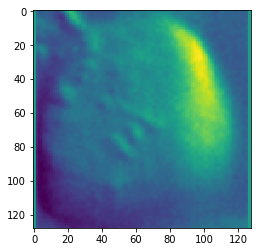

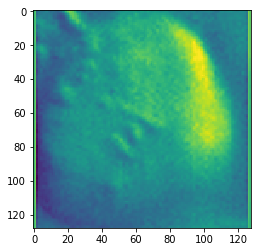

((96, 128, 128, 1), (96, 3))
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [5]:
train_data,train_label=prep_icnn_am_train_data(train_path,obj_h,obj_w)
print(train_data.shape,train_label.shape)
print(train_label)

In [41]:
ylabel=np.argmax(train_label,axis=1)
label_weight=class_weight.compute_class_weight('balanced', np.unique(ylabel), ylabel.flatten())
print(label_weight)

[0.62235067 1.38626609 1.48847926]


In [42]:
def class_weighted_crossentropy(class_weight):  
    def loss(y_true, y_pred):
        y_pred  = tf.clip_by_value(y_pred, 10e-8, 1.-10e-8)
        return -tf.reduce_sum(y_true * class_weight * tf.log(y_pred))
    return loss

In [43]:
model.compile(loss=class_weighted_crossentropy(label_weight), optimizer='adam', metrics=["accuracy"])

In [8]:
batch_size = 50
nb_epoch=500
history =model.fit_generator(data_gen.flow(train_data,train_label,batch_size=batch_size),
                                     steps_per_epoch=len(train_data)/batch_size, epochs=nb_epoch, verbose=1)
model.save_weights(weight_file)